# Comparing different clustering algorithms on toy datasets

Adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

This example aims at showing characteristics of different clustering algorithms on datasets that are “interesting” but still in 2D. The last dataset is an example of a ‘null’ situation for clustering: the data is homogeneous, and there is no good clustering.

While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.

The results could be improved by tweaking the parameters for each clustering strategy, for instance setting the number of clusters for the methods that needs this parameter specified. Note that affinity propagation has a tendency to create many clusters. Thus in this example its two parameters (damping and per-point preference) were set to to mitigate this behavior.

In [1]:
using ScikitLearn
using PyPlot

@sk_import datasets: (make_circles, make_moons, make_blobs)
@sk_import cluster: (estimate_bandwidth, MeanShift, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering)
@sk_import cluster: (DBSCAN, AffinityPropagation, Birch)
@sk_import preprocessing: StandardScaler
@sk_import neighbors: kneighbors_graph

PyObject <function kneighbors_graph at 0x7f3b343fdf50>

In [2]:
srand(33)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)
no_structure = rand(n_samples, 2), nothing

colors0 = collect("bgrcmykbgrcmykbgrcmykbgrcmyk")
colors = vcat(fill(colors0, 20)...)

clustering_names = [
    "MiniBatchKMeans", "AffinityPropagation", "MeanShift",
    "SpectralClustering", "Ward", "AgglomerativeClustering",
    "DBSCAN", "Birch"];

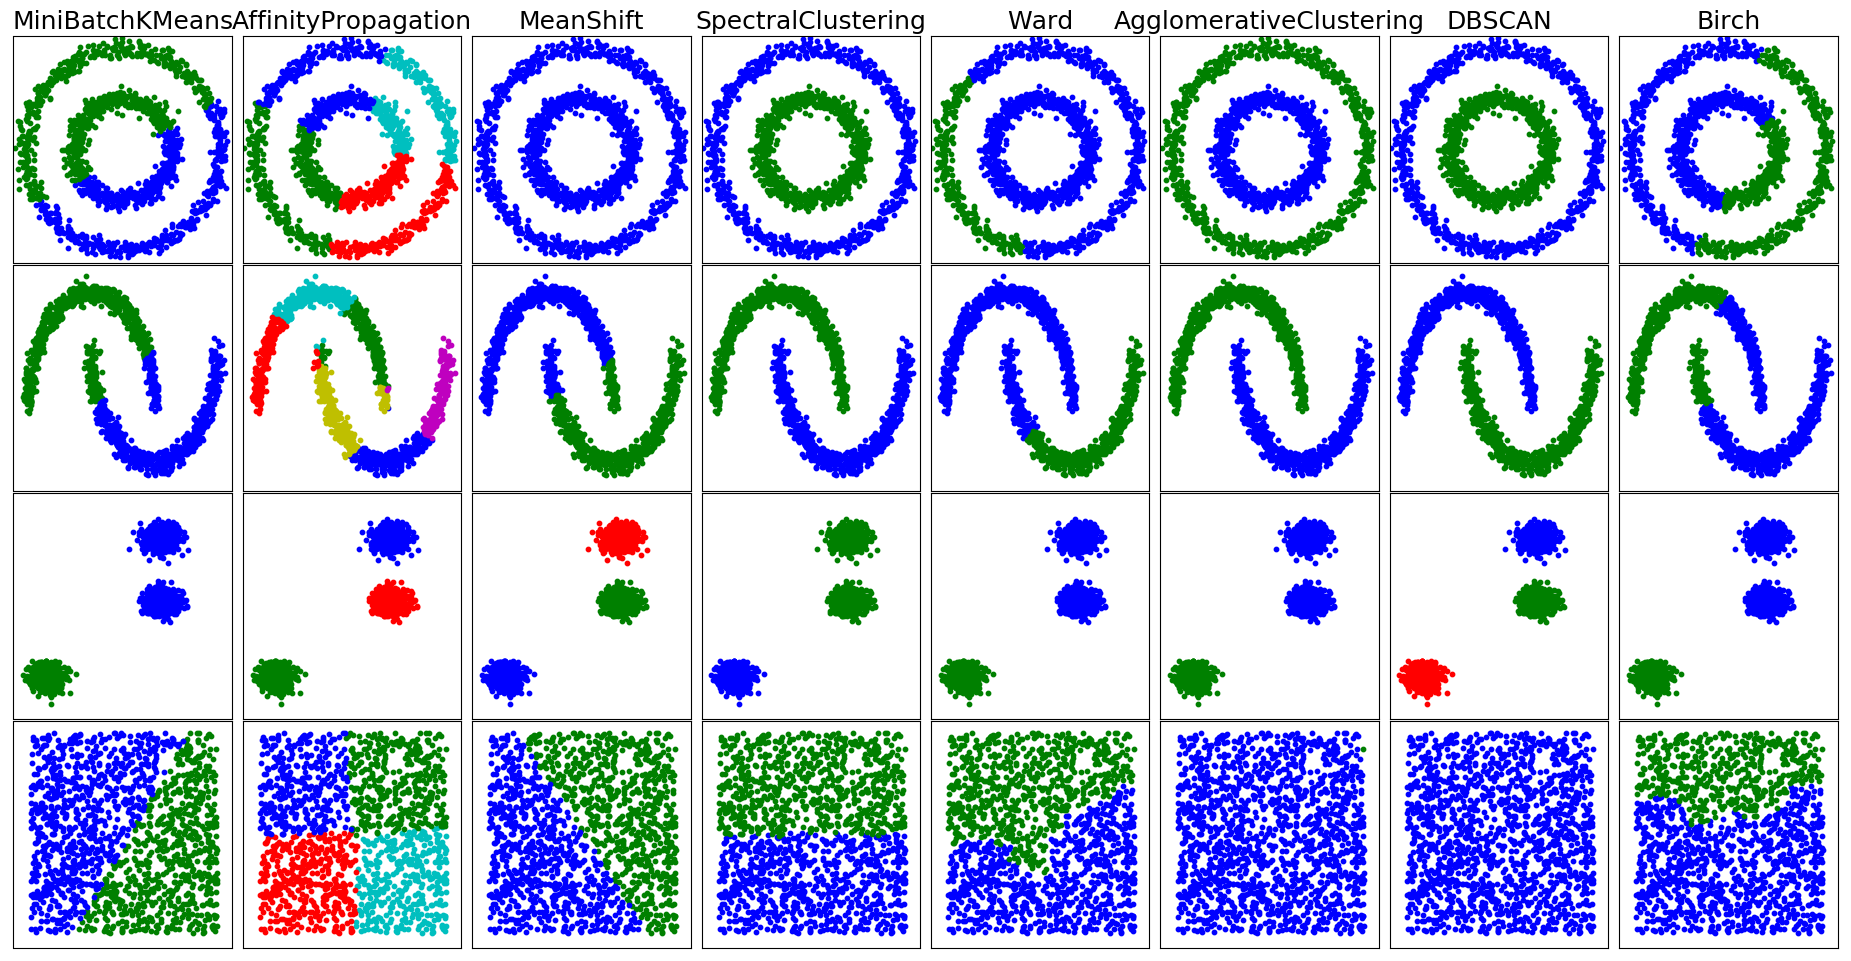

/usr/lib/python2.7/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python2.7/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/lib/python2.7/dist-packages/scipy/sparse/sputils.py:141: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead

In [3]:
figure(figsize=(length(clustering_names) * 2 + 3, 9.5))
subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]

for (i_dataset, dataset) in enumerate(datasets)

    X, y = dataset
    # normalize dataset for easier parameter selection
    X = fit_transform!(StandardScaler(), X)

    # estimate bandwidth for mean shift
    bandwidth = estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=false)[:todense]() # PyCall does not support numpy sparse matrices
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity')

    # create clustering estimators
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=true)
    two_means = MiniBatchKMeans(n_clusters=2)
    ward = AgglomerativeClustering(n_clusters=2, linkage="ward",
                                   connectivity=connectivity)
    spectral = SpectralClustering(n_clusters=2,
                                  eigen_solver="arpack",
                                  affinity="nearest_neighbors")
    dbscan = DBSCAN(eps=.2)
    affinity_propagation = AffinityPropagation(damping=.9, preference=-200)

    average_linkage = AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    birch = Birch(n_clusters=2)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for (name, algorithm) in zip(clustering_names, clustering_algorithms)
        fit!(algorithm, X)
        y_pred = nothing
        try
            y_pred = predict(algorithm, X)
        catch e
            if isa(e, KeyError)
                y_pred = map(Int, algorithm[:labels_])
                clamp!(y_pred, 0, 27) # not sure why some algorithms return -1
            else rethrow() end
        end
        subplot(4, length(clustering_algorithms), plot_num)
        if i_dataset == 1
            title(name, size=18)
        end

        for y_val in unique(y_pred)
            selected = y_pred.==y_val
            scatter(X[selected, 1], X[selected, 2], color=string(colors0[y_val+1]), s=10)
        end

        xlim(-2, 2)
        ylim(-2, 2)
        xticks(())
        yticks(())
        plot_num += 1
    end
end